In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from numba import jit

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from matplotlib.animation import FuncAnimation  #creating animations and videos.
from IPython.display import Video, HTML         #embedding videos in the notebook

%matplotlib inline

In [2]:
def plot_state(X,Y,theta,colors):   
    u=1
    U=u*np.cos(theta)
    V=u*np.sin(theta)
    
    #plt.figure(figsize=(10,10))
    plt.scatter(X,Y,30,c=colors,alpha=0.5)
    plt.quiver(X,Y,U,V,colors, scale=30)
    plt.xlim((-1,1))
    plt.ylim((-1,1))
    plt.xticks([]),plt.yticks([])
    

def plot_state3D(X,Y,theta,colors):   
    
    ax=plt.axes(projection='3d');
    
    ax.scatter3D(X,Y,np.sin(theta), c=colors, marker="o",s=50,alpha=0.5);
    
    ax.set_xlim((-1,1))
    ax.set_ylim((-1,1))
    ax.set_zlim(-1,1) 
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('sin[Theta]')


In [3]:
#@jit(nopython=True)
def initialize_random(N=100, plot=True):
    X=np.random.uniform(-1,1,N)
    Y=np.random.uniform(-1,1,N)
    theta=2*np.pi*np.random.uniform(-1,1,N)
    theta=theta-np.mean(theta)
    colors=np.random.uniform(-1,1,N)
    
    u=1
    U=u*np.cos(theta)
    V=u*np.sin(theta)

    if plot: plot_state(X,Y,theta,colors)
        
    return X,Y,theta,colors

In [4]:
@jit(nopython=True)
def calc_trajectories(X,Y,theta, u=1,dt=0.01,th_noise=0.025,l=0.05, Nt=10):
    l2=l**2
    n=X.shape[0]
    x, y, th = np.zeros((n,Nt)), np.zeros((n,Nt)), np.zeros((n,Nt))

    for j in range(0,Nt):
        #Calculate velocities, the speed is the same.
        U=u*np.cos(theta)
        V=u*np.sin(theta)
        theta_new=theta.copy()
        #update coordinates
        X=X+U*dt;
        Y=Y+V*dt;

        #Simple double-periodicity (not entirely correct though!)
        X[X>1]=-1 +X[X>1]-1
        Y[Y>1]=-1 +Y[Y>1]-1
        X[X<-1]=1 +X[X<-1]+1
        Y[Y<-1]=1 +Y[Y<-1]+1

        #calculate average direction angle based on a radius of influence
        for i in range(1,n):
            L2=(X-X[i])**2+(Y-Y[i])**2
            theta_new[i]=np.mean(theta[L2<l2])

        theta_rand=th_noise*(2*np.random.uniform(0,1,n)-1)*2*np.pi # noise

        theta=theta_new + theta_rand # add the noise to the direction angle

        theta=theta % (2*np.pi) #keep the angles bounded to [0 2pi]

        x[:,j]=X; y[:,j]=Y; th[:,j]=theta;

    return x,y,th
    

In [5]:
X,Y,theta,colors=initialize_random(N=1000, plot=False)

In [7]:
%%time
x,y,th=calc_trajectories(X,Y,theta, u=1,dt=0.01,th_noise=0.02, Nt=1000);

CPU times: user 6.99 s, sys: 79 ms, total: 7.06 s
Wall time: 8.29 s


In [8]:
#plotting figures movie-like 
#nt=x.shape[1]
#plt.figure(figsize=(10,10));
#for j in range(nt):
#    if j % 5==0:
#        display.display(plt.gcf());
#        plt.clf();
#        plot_state(x[:,j],y[:,j],th[:,j],colors);
#        display.clear_output(wait=True)
#        time.sleep(0.1)

In [9]:
n_skip=5 # plotting every n_skip time frame from the simulation to speed things up
N_frames=x.shape[1]//n_skip   # number of frames to plot for the video

def animation_func(j):
    fig.clear()
    #plot_state(x[:,n_skip*j],y[:,n_skip*j],th[:,n_skip*j],colors);
    plot_state3D(x[:,n_skip*j],y[:,n_skip*j],th[:,n_skip*j],colors)

fig = plt.figure(figsize=(10,10))
animation = FuncAnimation(fig, animation_func, 
                          frames = N_frames)

animation.save('swarming.mp4')
plt.close()
Video('swarming.mp4')

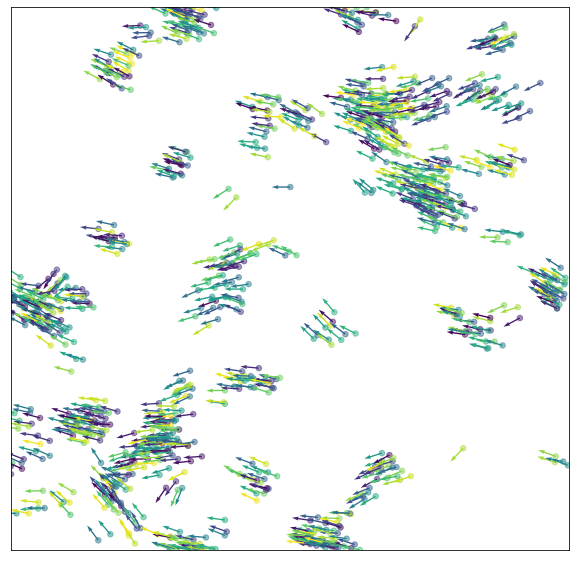

In [10]:
j=100;

fig = plt.figure(figsize=(10,10))
plot_state(x[:,j],y[:,j],th[:,j],colors);
#plot_state3D(x[:,j],y[:,j],th[:,j],colors)

In [11]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

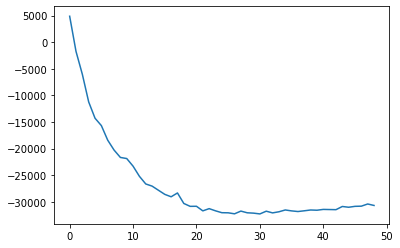

In [12]:
j=500;


xyz=np.stack((x[:,j],
              y[:,j],
              np.cos(th[:,j]),
              np.sin(th[:,j])),
              axis=1);


xyz=np.stack((x[:,j],y[:,j],np.cos(np.pi*x[:,j]),np.sin(np.pi*x[:,j]),
              np.cos(np.pi*y[:,j]),np.sin(np.pi*y[:,j]),
              np.cos(th[:,j]),
              np.sin(th[:,j])),
              axis=1);





BIC=np.array([]);
for K in range(1,50):
    gmm = GaussianMixture(n_components=K)
    gmm.fit_predict(xyz)
    bic=gmm.bic(xyz)
    BIC=np.append(BIC,bic)
plt.plot(BIC);  


Best K =  30


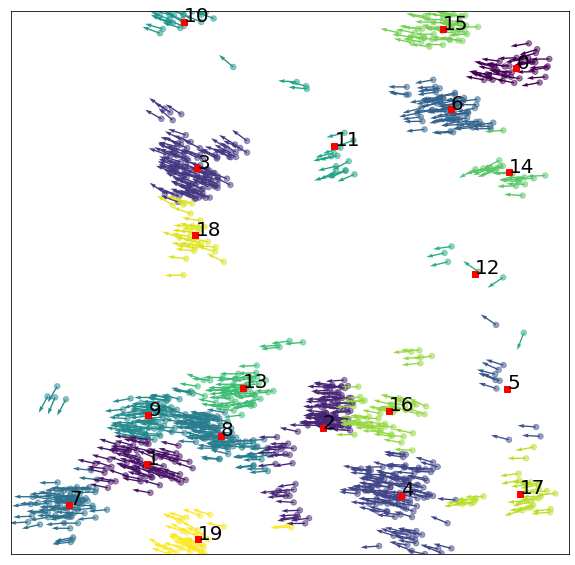

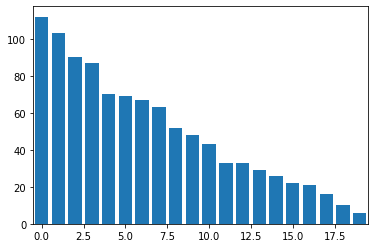

In [15]:
K=np.argmin(BIC)
print('Best K = ',K );
K=20

#kmeans = KMeans(n_clusters=K).fit(xyz)
#x_mean, y_mean =kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1]
#labels=kmeans.labels_

gmm = GaussianMixture(n_components=K)
labels=gmm.fit_predict(xyz)
x_mean,y_mean=gmm.means_[:,0],gmm.means_[:,1]


fig = plt.figure(figsize=(10,10))
plot_state(x[:,j],y[:,j],th[:,j],labels)

for k in range(K):
    plt.plot(x_mean[k],y_mean[k],'rs',markersize=6)
    plt.annotate(str(k), (x_mean[k],y_mean[k]), fontsize=20)    
    
values, counts = np.unique(labels, return_counts=True)


fig = plt.figure(figsize=(6,4))
plt.bar(values,-np.sort(-counts)); 
plt.xlim((-0.5,K-0.5));


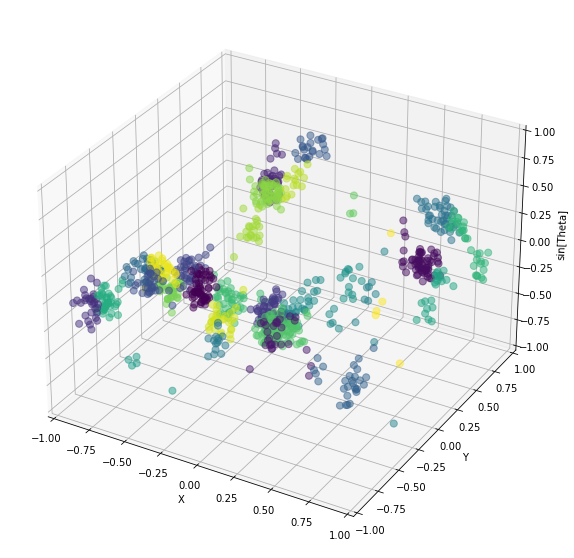

In [14]:
fig = plt.figure(figsize=(10,10))
plot_state3D(x[:,j],y[:,j],th[:,j],labels)